In [1]:
import argparse
import glob
import json
import os
import pathlib
import pickle
import pickle as pkl
import shutil
import sys
import time
import warnings
from collections import defaultdict
from typing import List, Optional, Union

import awkward as ak
import numpy as np
import pandas as pd
import yaml

pd.options.mode.chained_assignment = None
sys.path.append("../")

import importlib.resources
import pickle
import sys
import warnings
from typing import Dict

import awkward as ak
import correctionlib
import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import uproot
from coffea import nanoevents, processor
from coffea import util as cutil
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods import candidate, vector
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray, JetArray

plt.style.use(hep.style.CMS)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pog_correction_path = "/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/"
pog_jsons = {
    "muon": ["MUO", "muon_Z.json.gz"],
    "electron": ["EGM", "electron.json.gz"],
    "pileup": ["LUM", "puWeights.json.gz"],
    "jec": ["JME", "fatJet_jerc.json.gz"],
    "btagging": ["BTV", "btagging.json.gz"],
}


def get_UL_year(year):
    if year == "2016":
        year = "2016postVFP"
    elif year == "2016APV":
        year = "2016preVFP"
    return f"{year}_UL"

def get_pog_json(obj, year):
    try:
        pog_json = pog_jsons[obj]
    except ValueError:
        print(f"No json for {obj}")
    year = get_UL_year(year)
    return f"{pog_correction_path}POG/{pog_json[0]}/{year}/{pog_json[1]}"

# Load some jets

In [4]:
### schema
nanoevents.PFNanoAODSchema.mixins["PFCands"] = "PFCand"
nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"

# load a ggF root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/ggh.root")
num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file: {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events", schemaclass=nanoevents.PFNanoAODSchema).events()

nevents = len(events)

weights = Weights(nevents, storeIndividual=True)
weights.weight()

number of events per file: 6000


/uscms/home/fmokhtar/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (2140 branches) at 0x7f8738986f70>, taking first instance
  warnings.warn(
/uscms/home/fmokhtar/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (2140 branches) at 0x7f8738986f70>, taking first instance
  warnings.warn(
/uscms/home/fmokhtar/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (2140 branches) at 0x7f8738986f70>, taking first instance
  warnings.warn(
/uscms/home/fmokhtar/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch

array([1., 1., 1., ..., 1., 1., 1.])

# Real

In [7]:
# from hww processor
fatjets = events.FatJet
good_fatjets = (fatjets.pt > 200) & (abs(fatjets.eta) < 2.5) & fatjets.isTight
jets = fatjets[good_fatjets]  # select good fatjets
jets

<FatJetArray [[FatJet, FatJet], ... [FatJet, FatJet]] type='6000 * var * fatJet'>

In [8]:
year = "2017"
wp = "L"
algo = "deepJet"

cset = correctionlib.CorrectionSet.from_file(get_pog_json("btagging", year))


sys.path.append("data")

ul_year = get_UL_year(year)

import boostedhiggs.data as data
with importlib.resources.path(data, f"btageff_{algo}_{wp}_{ul_year}.coffea") as filename:
    efflookup = cutil.load(filename)
                          
efflookup

3 dimensional histogram with axes:
	1: [ 40.  53.  66.  79.  92. 105. 118. 131. 144. 157. 170. 183. 196. 209.
 222. 235. 248. 261. 274. 287. 300.]
	2: [0.    0.625 1.25  1.875 2.5  ]
	3: [0. 1. 2. 3.]

In [9]:
def _btagSF(cset, jets, flavour, wp="M", algo="deepJet", syst="central"):
    j, nj = ak.flatten(jets), ak.num(jets)
    corrs = cset[f"{algo}_comb"] if flavour == "bc" else cset[f"{algo}_incl"]
    sf = corrs.evaluate(
        syst,
        wp,
        np.array(j.hadronFlavour),
        np.array(abs(j.eta)),
        np.array(j.pt),
    )
    return ak.unflatten(sf, nj)

# mutually exclusive and complete set
lightJets = jets[(jets.hadronFlavour == 0)]
bcJets = jets[(jets.hadronFlavour > 0)]

# get efficiency
lightEff = efflookup(lightJets.pt, abs(lightJets.eta), lightJets.hadronFlavour)
bcEff = efflookup(bcJets.pt, abs(bcJets.eta), bcJets.hadronFlavour)

# get sf
lightSF = _btagSF(cset, lightJets, "light", wp, algo)
bcSF = _btagSF(cset, bcJets, "bc", wp, algo)

In [10]:
# multiplies each jet probability with other jets per event (default is 1 if there are no jets)
light_probs = ak.fill_none(ak.prod(1 - lightSF * lightEff, axis=-1), 1)
light_probs

<Array [0.8, 0.794, 0.802, ... 0.94, 0.64] type='6000 * float64'>

In [11]:
# multiplies each jet probability with other jets per event (default is 1 if there are no jets)
bc_probs = ak.fill_none(ak.prod(1 - bcSF * bcEff, axis=-1), 1)
bc_probs

<Array [1, 1, 1, 1, 0.102, ... 0.206, 1, 1, 1] type='6000 * float64'>

In [12]:
weight = (light_probs * bc_probs)
weight

<Array [0.8, 0.794, 0.802, ... 0.94, 0.64] type='6000 * float64'>

(array([1808.,  251.,   64.,    7.,   61.,  128.,  379.,  851.,  757.,
        1694.]),
 array([5.35259582e-05, 1.00048173e-01, 2.00042821e-01, 3.00037468e-01,
        4.00032116e-01, 5.00026763e-01, 6.00021410e-01, 7.00016058e-01,
        8.00010705e-01, 9.00005353e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

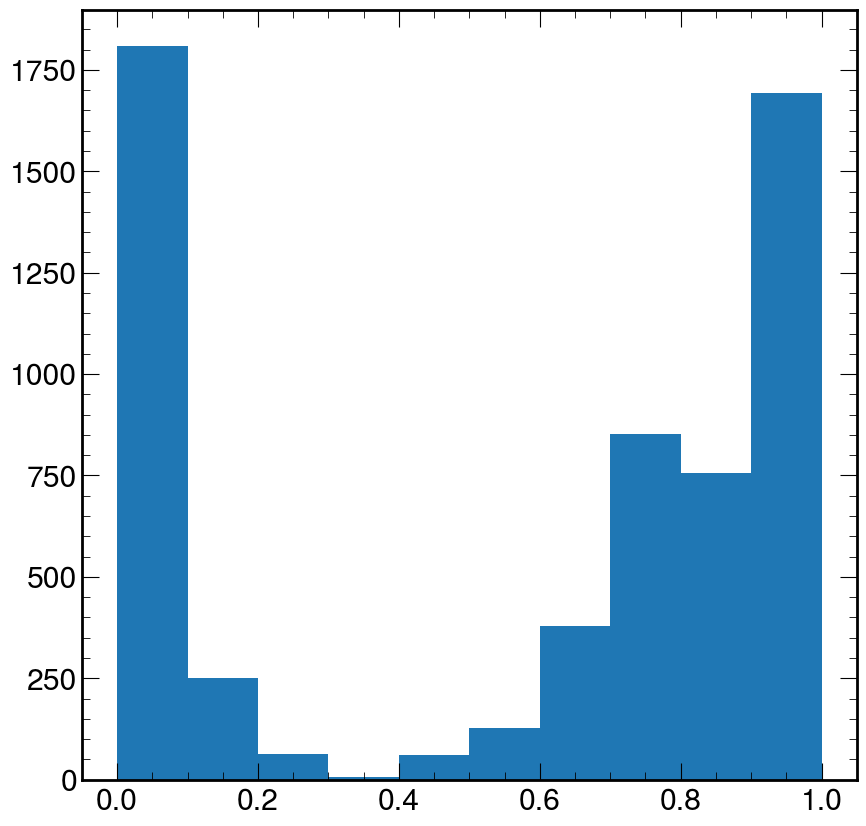

In [13]:
plt.hist(weight)